In [1]:
from graph2vec import *
import pandas as pd 

#### Read table and assign labels

In [2]:
patients = pd.read_excel(r'C:\Users\efeka\Desktop\TubitakData\2025.01.03_mri_patients_features\combined_24_with_external_features_6months.xlsx')
patients["Diagnosis"] = patients["Diagnosis"].str.strip() # remove leading and trailing whitespaces
patients = patients[patients["MRI Machine"] != "Error"]
# patients = patients[patients["MRI Machine"] == "EG ARS"]
# patients = patients[patients["MRI Machine"] == "EAH"]

label_0_dxs = ["MCI", "MCI-AD", "MCI-VD"]
label_1_dxs = ["AD"]

def assign_label(diagnosis):
    if diagnosis in label_0_dxs:
        return 0
    elif diagnosis in label_1_dxs:
        return 1
    else:
        return None  # Use None for diagnoses not in either list (optional)

patients['Label'] = patients['Diagnosis'].apply(assign_label)

In [3]:
patients['Label'].value_counts()

Label
1.0    145
0.0    105
Name: count, dtype: int64

### Convert to graphs

In [6]:
import networkx as nx
import pandas as pd 
import os
import pickle

# Create an undirected weighted graph
graph_folder = '../tubitak_graphs/MIND_filtered_vertices/'
csv_list = os.listdir(graph_folder)
for csv in csv_list:
    if csv.endswith('.csv'):
        adj_df = pd.read_csv(graph_folder + csv)
        adj_df.index = adj_df.columns
        G = nx.from_pandas_adjacency(adj_df)
        # Save the graph
        with open ('../tubitak_graphs/nx_filtered_vertices/' + csv.replace('.csv', '.pickle'), 'wb') as f:
            pickle.dump(G, f)
    # To load:
    # with open('mind_adni1_bl_tiny/graphs/' + csv.replace('.csv', '.pickle'), 'rb') as f:
    #     G_loaded = pickle.load(f)



### PCA

In [4]:
# --- Load graphs and labels ---
graph_list = []
label_list = []

apply_thresholding = True
threshold = 0.35 # Set the threshold for edge weights

graph_dir = '../tubitak_graphs/nx_filtered_vertices'
for fname in os.listdir(graph_dir):
    subject_name = fname.replace('.pickle', '').upper()
    if fname.endswith('.pickle') and subject_name in patients['Subject_Name'].values:
        with open(os.path.join(graph_dir, fname), 'rb') as f:
            G = pickle.load(f)
            if apply_thresholding:
                graph_list.append(remove_low_weight_edges(G, threshold))
            else:
                graph_list.append(G)
            ptid = fname.replace('.pickle', '').upper()
            label = patients[patients['Subject_Name'] == subject_name]['Label'].values[0]
            label_list.append(label)
        print(f"Loaded graph for {subject_name} with label {label}.")
    elif fname.endswith('.pickle') and subject_name not in patients['Subject_Name'].values:
        print(f"Warning: {subject_name} not found in patients DataFrame. Skipping this graph file.")
        continue

Loaded graph for ABDULKADIR_CALISKAN_FOLDER with label 0.0.
Loaded graph for ABDULLAH_RENCBER_FOLDER with label 1.0.
Loaded graph for ABDURRAHMAN_IPEK2_FOLDER with label 0.0.
Loaded graph for ABDURRAHMAN_IPEK_FOLDER with label 0.0.
Loaded graph for ADILE_AY_FOLDER with label nan.
Loaded graph for ADIL_ERGUN_FOLDER with label 1.0.
Loaded graph for AHMET_ACAR_FOLDER with label nan.
Loaded graph for AHMET_DULGER_FOLDER with label nan.
Loaded graph for AHMET_DURAN_ESER_FOLDER with label 1.0.
Loaded graph for AHMET_KAYNAK_FOLDER with label 0.0.
Loaded graph for AHMET_VARDAR_FOLDER with label nan.
Loaded graph for AHMET_YASAR_KILIC2_FOLDER with label 1.0.
Loaded graph for AHMET_YASAR_KILIC_FOLDER with label 0.0.
Loaded graph for AHMET_YASAR_ZENGIN2_FOLDER with label 0.0.
Loaded graph for AHMET_YILMAZ2_FOLDER with label nan.
Loaded graph for AHMET_YILMAZ_FOLDER with label nan.
Loaded graph for AKIF_GULTEKIN_FOLDER with label 1.0.
Loaded graph for ALAYITTIN_YILMAZ_FOLDER with label 0.0.
Loaded

In [5]:
#patients['Subject_Name'].values
graph_dir_subjects = [fname.replace('.pickle', '').upper() for fname in os.listdir(graph_dir)]
# Find the difference between patients['Subject_Name'].values and graph_dir_subjects
missing_subjects =   set(graph_dir_subjects) - set(patients['Subject_Name'].values)
# missing_subjects

In [6]:
i = 0 
for graph in graph_list:
    if graph.number_of_nodes() != 68:

        i += 1	
        continue
print(f"Number of graphs with 68 nodes: {len(graph_list) - i}")
print(f"Number of graphs with less than 68 nodes: {i}")

Number of graphs with 68 nodes: 242
Number of graphs with less than 68 nodes: 31


In [7]:
len(graph_list), len(label_list), len(patients['Subject_Name'].values)

(273, 273, 321)

In [8]:
label_list = np.array(label_list)
# value counts in label list
np.unique(label_list, return_counts=True)

(array([ 0.,  1., nan]), array([100, 104,  69], dtype=int64))

In [9]:
import numpy as np

label_array = np.array(label_list)
valid_indices = ~np.isnan(label_array)

# Apply the mask
label_list = label_array[valid_indices].tolist()
graph_list = [graph_list[i] for i in range(len(graph_list)) if valid_indices[i]]
len(graph_list), len(label_list), len(patients['Subject_Name'].values)

(204, 204, 321)

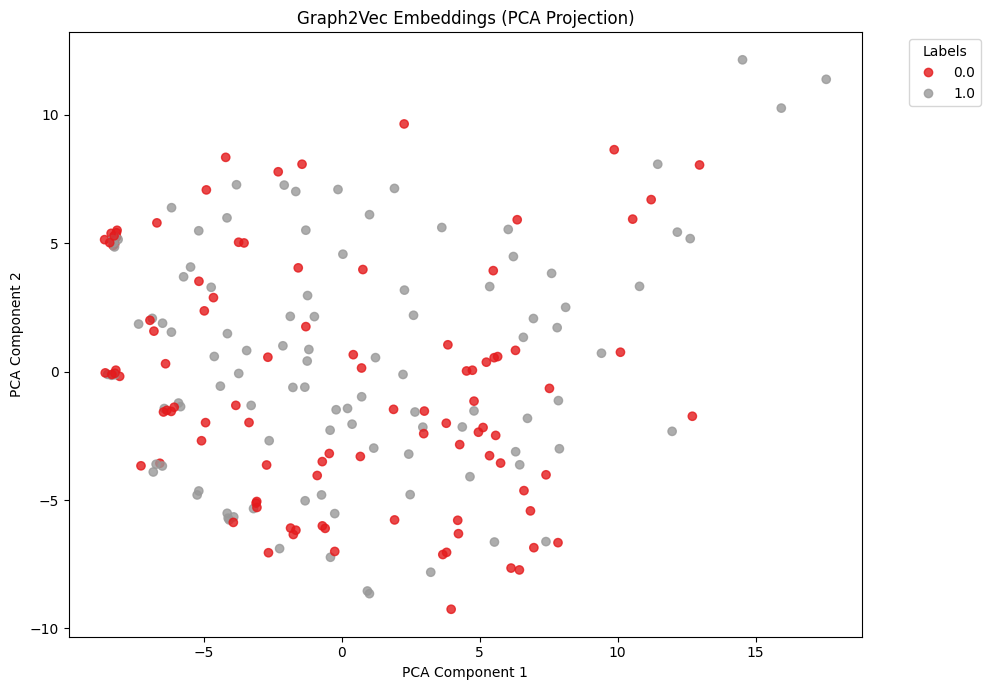

In [13]:
# --- Prepare documents for Doc2Vec ---
documents = [TaggedDocument(words=extract_wl_features(g, h=3), tags=[str(i)]) for i, g in enumerate(graph_list)]

# --- Train Doc2Vec (Graph2Vec) ---
model = Doc2Vec(vector_size=128, window=7, min_count=1, workers=4, epochs=50, dm=0)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

# --- Extract graph-level embeddings ---
graph_embeddings = np.array([model.dv[str(i)] for i in range(len(graph_list))])

# --- Optional: Scale before PCA ---
scaler = StandardScaler()
graph_embeddings_scaled = scaler.fit_transform(graph_embeddings)

# --- PCA Reduction ---
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(graph_embeddings_scaled)

# --- Encode labels ---
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_list)

# --- Plot ---
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=encoded_labels,
    cmap='Set1',
    alpha=0.8
)
handles, _ = scatter.legend_elements()
plt.legend(handles, label_encoder.classes_, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Graph2Vec Embeddings (PCA Projection)")
plt.tight_layout()
plt.show()


In [18]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import numpy as np

# --- Split data into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    graph_embeddings_scaled, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# --- Choose a classifier ---
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=3,
    random_state=42,
    max_features='sqrt',
    class_weight='balanced'
)
# clf = LogisticRegression(max_iter=1000)

# --- Train the model ---
clf.fit(X_train, y_train)

# --- Evaluate on Test Set ---
y_pred = clf.predict(X_test)

print("Test Set Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- Cross-Validation Evaluation ---
y_cv_pred = cross_val_predict(clf, graph_embeddings_scaled, encoded_labels, cv=5)

print("\nCross-Validation Classification Report:")
print(classification_report(encoded_labels, y_cv_pred, target_names=[str(cls) for cls in label_encoder.classes_]))

print("Cross-Validation Confusion Matrix:")
print(confusion_matrix(encoded_labels, y_cv_pred))

# Optional: Show average cross-val accuracy too
scores = cross_val_score(clf, graph_embeddings_scaled, encoded_labels, cv=5)
print("5-Fold Cross-Validation Accuracy:", np.mean(scores))


Test Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.65      0.59        20
         1.0       0.59      0.48      0.53        21

    accuracy                           0.56        41
   macro avg       0.56      0.56      0.56        41
weighted avg       0.57      0.56      0.56        41

Test Set Confusion Matrix:
[[13  7]
 [11 10]]

Cross-Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.45      0.43      0.44       100
         1.0       0.48      0.50      0.49       104

    accuracy                           0.47       204
   macro avg       0.46      0.46      0.46       204
weighted avg       0.47      0.47      0.47       204

Cross-Validation Confusion Matrix:
[[43 57]
 [52 52]]
5-Fold Cross-Validation Accuracy: 0.4654878048780488


### GIN

In [14]:
import os
import pickle
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch.nn import Linear, Sequential, ReLU
import networkx as nx
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# --------------------------
# Convert NetworkX to PyG Data
# --------------------------
def convert_nx_to_pyg_data(graph, label):
    graph = nx.convert_node_labels_to_integers(graph)
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

    if edge_index.numel() == 0:
        return None  # Skip empty graphs

    num_nodes = graph.number_of_nodes()
    x = torch.ones((num_nodes, 1))  # Dummy features
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

# --------------------------
# Prepare Dataset
# --------------------------
pyg_graphs = []
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_list)

for nx_graph, label in zip(graph_list, encoded_labels):
    data = convert_nx_to_pyg_data(nx_graph, label)
    if data is not None:
        pyg_graphs.append(data)

labels_np = np.array([data.y.item() for data in pyg_graphs])

# --------------------------
# GIN Model Definition
# --------------------------
class GIN(torch.nn.Module):
    def __init__(self, hidden_dim, num_classes):
        super().__init__()
        nn1 = Sequential(Linear(1, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
        nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))

        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)
        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# --------------------------
# Cross-Validation Loop
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

all_preds, all_true = [], []

for fold, (train_idx, test_idx) in enumerate(skf.split(pyg_graphs, labels_np)):
    print(f"\n--- Fold {fold+1} ---")

    train_dataset = [pyg_graphs[i] for i in train_idx]
    test_dataset = [pyg_graphs[i] for i in test_idx]

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    model = GIN(hidden_dim=64, num_classes=len(label_encoder.classes_)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Train
    for epoch in range(1, 31):  # Reduce epochs for faster CV
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch:02d}, Loss: {total_loss:.4f}")

    # Evaluate
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(batch.y.cpu().numpy())

    print(f"Fold {fold+1} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    all_preds.extend(y_pred)
    all_true.extend(y_true)

# --------------------------
# Final Evaluation
# --------------------------
print("\n--- Overall Classification Report ---")
print(classification_report(all_true, all_preds, target_names=[str(c) for c in label_encoder.classes_]))



--- Fold 1 ---


c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Loss: 1470.5460
Epoch 02, Loss: 491.9501
Epoch 03, Loss: 85.8608
Epoch 04, Loss: 89.2243
Epoch 05, Loss: 66.2134
Epoch 06, Loss: 166.7233
Epoch 07, Loss: 112.0605
Epoch 08, Loss: 190.0210
Epoch 09, Loss: 261.4341
Epoch 10, Loss: 183.0743
Epoch 11, Loss: 74.2713
Epoch 12, Loss: 56.2730
Epoch 13, Loss: 55.4636
Epoch 14, Loss: 31.7927
Epoch 15, Loss: 15.5641
Epoch 16, Loss: 17.8133
Epoch 17, Loss: 11.5919
Epoch 18, Loss: 22.9376
Epoch 19, Loss: 30.7447
Epoch 20, Loss: 48.1259
Epoch 21, Loss: 48.9433
Epoch 22, Loss: 42.7734
Epoch 23, Loss: 25.4070
Epoch 24, Loss: 51.9871
Epoch 25, Loss: 42.8119
Epoch 26, Loss: 20.7313
Epoch 27, Loss: 12.7064
Epoch 28, Loss: 15.4432
Epoch 29, Loss: 10.4159
Epoch 30, Loss: 20.0440
Fold 1 Accuracy: 0.4878

--- Fold 2 ---


c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Loss: 947.2423
Epoch 02, Loss: 1355.5197
Epoch 03, Loss: 730.1227
Epoch 04, Loss: 591.2444
Epoch 05, Loss: 350.7777
Epoch 06, Loss: 90.6437
Epoch 07, Loss: 33.4706
Epoch 08, Loss: 25.2827
Epoch 09, Loss: 56.1586
Epoch 10, Loss: 58.3913
Epoch 11, Loss: 129.8538
Epoch 12, Loss: 67.4833
Epoch 13, Loss: 15.8303
Epoch 14, Loss: 30.7620
Epoch 15, Loss: 122.7291
Epoch 16, Loss: 43.9907
Epoch 17, Loss: 34.2348
Epoch 18, Loss: 27.9735
Epoch 19, Loss: 18.1016
Epoch 20, Loss: 17.0597
Epoch 21, Loss: 22.6497
Epoch 22, Loss: 32.3474
Epoch 23, Loss: 18.4760
Epoch 24, Loss: 10.8980
Epoch 25, Loss: 9.3302
Epoch 26, Loss: 15.2107
Epoch 27, Loss: 13.2705
Epoch 28, Loss: 19.5209
Epoch 29, Loss: 18.7794
Epoch 30, Loss: 27.7226
Fold 2 Accuracy: 0.4878

--- Fold 3 ---


c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Loss: 1293.7548
Epoch 02, Loss: 828.9984
Epoch 03, Loss: 423.4089
Epoch 04, Loss: 112.8348
Epoch 05, Loss: 167.3427
Epoch 06, Loss: 68.2176
Epoch 07, Loss: 131.5149
Epoch 08, Loss: 113.4322
Epoch 09, Loss: 70.0225
Epoch 10, Loss: 41.1644
Epoch 11, Loss: 60.0766
Epoch 12, Loss: 38.4147
Epoch 13, Loss: 149.7619
Epoch 14, Loss: 123.5605
Epoch 15, Loss: 62.0190
Epoch 16, Loss: 28.9850
Epoch 17, Loss: 19.1893
Epoch 18, Loss: 15.1276
Epoch 19, Loss: 22.2038
Epoch 20, Loss: 54.3166
Epoch 21, Loss: 23.3767
Epoch 22, Loss: 29.7411
Epoch 23, Loss: 39.5916
Epoch 24, Loss: 42.1991
Epoch 25, Loss: 65.4651
Epoch 26, Loss: 53.4405
Epoch 27, Loss: 35.9365
Epoch 28, Loss: 32.9266
Epoch 29, Loss: 33.8363
Epoch 30, Loss: 22.3062
Fold 3 Accuracy: 0.4878

--- Fold 4 ---


c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Loss: 495.6210
Epoch 02, Loss: 99.9177
Epoch 03, Loss: 172.3357
Epoch 04, Loss: 94.8961
Epoch 05, Loss: 102.5812
Epoch 06, Loss: 79.5480
Epoch 07, Loss: 41.8215
Epoch 08, Loss: 65.8510
Epoch 09, Loss: 179.4665
Epoch 10, Loss: 94.5157
Epoch 11, Loss: 121.8372
Epoch 12, Loss: 164.3324
Epoch 13, Loss: 151.3615
Epoch 14, Loss: 65.2454
Epoch 15, Loss: 34.6294
Epoch 16, Loss: 86.4216
Epoch 17, Loss: 28.9947
Epoch 18, Loss: 16.3228
Epoch 19, Loss: 11.9733
Epoch 20, Loss: 15.5724
Epoch 21, Loss: 30.4369
Epoch 22, Loss: 16.8531
Epoch 23, Loss: 12.1962
Epoch 24, Loss: 11.6692
Epoch 25, Loss: 14.8347
Epoch 26, Loss: 10.0607
Epoch 27, Loss: 13.3890
Epoch 28, Loss: 9.6733
Epoch 29, Loss: 9.3283
Epoch 30, Loss: 9.6455
Fold 4 Accuracy: 0.4878

--- Fold 5 ---


c:\Users\efeka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 01, Loss: 767.4625
Epoch 02, Loss: 98.2761
Epoch 03, Loss: 227.0128
Epoch 04, Loss: 277.7482
Epoch 05, Loss: 100.1866
Epoch 06, Loss: 54.7818
Epoch 07, Loss: 124.2581
Epoch 08, Loss: 294.9281
Epoch 09, Loss: 93.4416
Epoch 10, Loss: 99.5253
Epoch 11, Loss: 76.4278
Epoch 12, Loss: 48.0680
Epoch 13, Loss: 53.2893
Epoch 14, Loss: 80.3054
Epoch 15, Loss: 20.4348
Epoch 16, Loss: 25.4312
Epoch 17, Loss: 48.9395
Epoch 18, Loss: 39.4597
Epoch 19, Loss: 17.1973
Epoch 20, Loss: 43.9567
Epoch 21, Loss: 72.9948
Epoch 22, Loss: 36.0984
Epoch 23, Loss: 23.9729
Epoch 24, Loss: 24.0402
Epoch 25, Loss: 10.9740
Epoch 26, Loss: 10.5015
Epoch 27, Loss: 10.3726
Epoch 28, Loss: 13.5281
Epoch 29, Loss: 11.3140
Epoch 30, Loss: 8.6300
Fold 5 Accuracy: 0.5000

--- Overall Classification Report ---
              precision    recall  f1-score   support

         0.0       0.49      0.80      0.61       100
         1.0       0.50      0.19      0.28       104

    accuracy                           0.49     